<a href="https://colab.research.google.com/github/HLCV-23/Inpainting-Detection/blob/Christian/project_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Related Work
## Inpainting
- https://arxiv.org/pdf/2102.12092.pdf  
  Dall-e
- https://arxiv.org/pdf/2112.10752.pdf  
  Stable-Diffusion

## GAN-generated images detection
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8397040  
  detection of images generated by GANs, no inpainting
- https://arxiv.org/pdf/2202.07145.pdf
  review of several GAN detection algorithms

## Diffusion-generated images detection
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10095167  
  studies the performance of GAN-detection models on images generated by diffusion models

## Inpainting Detection
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9410590  
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9506778&tag=1  
  similar to our detection approach, but with random(?) masks. It compares the performance on deep learning and traditional inpainting techniques, which might be of interest for us (both for training and evaluation). We could also use the network architecture proposed here. Additional open-source dataset we might want to use.

## Image/Network Watermarking
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=650120  
  not directly related, but in watermarking, it is common to test the robustness of image watermarking techniques against common image preprocessing(rescaling, compression, etc). We might want to do that in our experiments too.
- https://www.usenix.org/system/files/conference/usenixsecurity18/sec18-adi.pdf
- https://tianweiz07.github.io/Papers/21-aamas.pdf  
- https://arxiv.org/abs/2305.20030 (Fourier Transform based technique to robustly watermark diffusion model outputs)
  

In [ ]:
import gc
import os
import torch
from PIL import Image
import requests
!pip install transformers
from transformers import SamModel, SamProcessor
import matplotlib.pyplot as plt
import numpy as np
!pip install diffusers
!pip install accelerate
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
!pip install xformers
import requests
import time
from transformers import pipeline
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from torch import cuda, bfloat16
import transformers
import torch
from transformers import StoppingCriteria, StoppingCriteriaList

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

In [ ]:
device = torch.device("cuda:0")

# count time
start_time = time.time()

print("LOADING MODEL")
print("time passed: "+str(time.time()-start_time))
print("\n")
generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=device)


img_url = "https://datasets-server.huggingface.co/assets/biglam/dating-historical-color-images/--/default/train/4/image/image.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB").resize((512,512))

#plt.imshow(raw_image)
#plt.show()

print("GENERATING MASKS")
print("time passed: "+str(time.time()-start_time))
print("\n")
outputs = generator(raw_image, points_per_batch=64)

print("SHOWING MASKS")
print("time passed: "+str(time.time()-start_time))
print("\n")
masks = outputs["masks"]
#show_masks_on_image(raw_image, masks)

LOADING MODEL
time passed: 0.00020194053649902344


GENERATING MASKS
time passed: 23.99623727798462


SHOWING MASKS
time passed: 32.27574324607849




In [ ]:
image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

caption = image_to_text(raw_image)[0]["generated_text"]
print(caption)

Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.0.attn.masked_bias', 'decoder.transformer.h.11.crossattention.bias', 'decoder.transformer.h.11.attn.bias', 'decoder.transformer.h.7.attn.bias', 'decoder.transformer.h.8.crossattention.bias', 'decoder.transformer.h.0.crossattention.masked_bias', 'decoder.transformer.h.10.crossattention.bias', 'decoder.transformer.h.2.crossattention.masked_bias', 'decoder.transformer.h.7.attn.masked_bias', 'decoder.transformer.h.5.crossattention.masked_bias', 'decoder.transformer.h.5.attn.masked_bias', 'decoder.transformer.h.9.attn.masked_bias', 'decoder.transformer.h.1.crossattention.bias', 'decoder.transformer.h.3.crossattention.masked_bias', 'decoder.transformer.h.11.crossattention.masked_bias', 'decoder.transformer.h.10.crossattention.masked_bias', 'decoder.transformer.h.4.crossattention.masked_bias', 'decoder.transformer.h.1.crossattention.ma

a man and woman sitting on a couch 


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Gustavosta/MagicPrompt-Stable-Diffusion")
model = AutoModelForCausalLM.from_pretrained("Gustavosta/MagicPrompt-Stable-Diffusion")
gpt2_pipe = pipeline("text-generation", model= model, tokenizer = tokenizer, device = device)

prompt = gpt2_pipe(caption)[0]["generated_text"]

print(prompt.split(","))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['a man and woman sitting on a couch  trying to eat popcorn', ' hyperrealistic', ' concept art', ' octane render', ' unreal engine 5', ' trending on Artstation', ' high quality', ' 8K', ' soft lighting', ' trending on DeviantArt', ' highly']


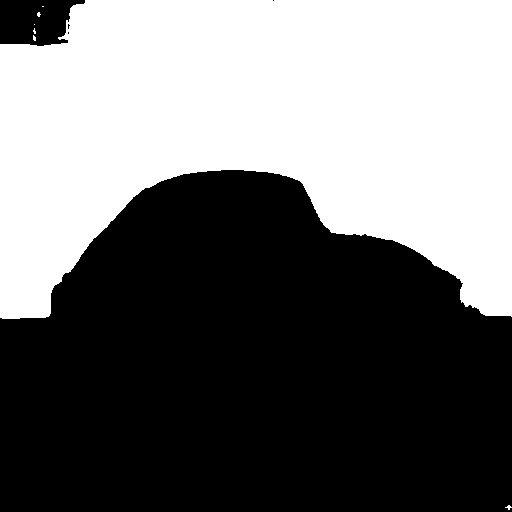

In [ ]:
mask_areas = []
for i in range(len(masks)):
  area = np.sum(masks[i])
  mask_areas.append(area)

min_area = np.mean(mask_areas)

while True:
  mask_id = np.random.choice(np.arange(len(masks)))

  area = np.sum(masks[mask_id])
  if area >= min_area:
    break

mask_img = Image.fromarray((masks[mask_id] * 255).astype(np.uint8).squeeze())
mask_img = mask_img.convert("RGB")
mask_img

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
    safety_checker=None,
    # Had to turn it off due to error with accelerate
    low_cpu_mem_usage = False
)
pipe.to("cuda:0")

### Generate Sample Images

Generate multiple versions of an image with different regions inpainted and return result as a matplotlib figure. Additionaly return figure containing all the masks of the regions that where inpainted in the image.


In [ ]:
import numpy as np
import requests
from PIL import Image
from matplotlib import pyplot as plt

# Calculate areas of all masks and store them with their indices
mask_areas = [(mask.sum(), idx) for idx, mask in enumerate(masks)]
# Sort mask_areas by area (in descending order) and take top 16
largest_masks = sorted(mask_areas, key=lambda x: x[0], reverse=True)[:16]

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

# Fetch the image once, as it doesn't change
img_url = "https://datasets-server.huggingface.co/assets/biglam/dating-historical-color-images/--/default/train/4/image/image.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB").resize((512,512))

for i, (_, mask_id) in enumerate(largest_masks):
    mask_img = Image.fromarray((masks[mask_id] * 255).astype(np.uint8).squeeze())
    mask_img = mask_img.convert("RGB")
    mask = np.expand_dims(masks[mask_id], axis=2)

    print(mask.shape)
    print(np.array(raw_image).shape)

    image = pipe(prompt=prompt, image=raw_image, mask_image=mask_img, height=512, width=512).images[0]
    print(f"Finished generating image {i}/{len(largest_masks)}")
    axs[i // 4, i % 4].imshow(image)
    axs[i // 4, i % 4].axis('off')

plt.savefig("mask_images_grid.png")
plt.show()

# Create a separate 5x5 grid for the masks
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, (_, mask_id) in enumerate(largest_masks):
    mask_img = Image.fromarray((masks[mask_id] * 255).astype(np.uint8).squeeze())
    axs[i // 4, i % 4].imshow(mask_img, cmap='gray')  # cmap='gray' for grayscale
    axs[i // 4, i % 4].axis('off')

plt.savefig("mask_grid.png")
plt.show()

# Dataset Generation

In [ ]:
# hugging face token is required to load dataset,
# go to https://huggingface.co/datasets/imagenet-1k/viewer/default/train
# and get a token in the account settings
!pip install datasets
!huggingface-cli login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.9 MB/s eta 0:00:00

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tok

In [ ]:
# download imagenet
from datasets import load_dataset, Dataset, Image
import pandas as pd
import os

dataset = load_dataset("scene_parse_150", use_auth_token = True, streaming = True, split = "train")
dataset = iter(dataset.shuffle())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#"""
!mkdir drive/MyDrive/Inpainted_Scenes
!touch drive/MyDrive/Inpainted_Scenes/Prompts.csv
!mkdir drive/MyDrive/Inpainted_Scenes/Images
!mkdir drive/MyDrive/Inpainted_Scenes/Masks
!pwd
#"""

/content


In [ ]:
#@title
from PIL import Image, ImageFilter

def generate_datapoint(dataset, id, csv_data, batch_size = 8):
    data = [next(dataset)["image"].resize((512,512)) for _ in range(batch_size)]
    print(data)
    masks = generator(data)
    masks = [d["masks"] for d in masks]
    # get mask
    mask_img = [Image.fromarray((curr_mask[0] * 255).astype(np.uint8).squeeze()).convert("RGB") for curr_mask in masks]
    plt.imshow(mask_img[0])
    plt.show()

    caption = [txt[0]["generated_text"] for txt in image_to_text(data)]
    prompt = [txt[0]["generated_text"] for txt in gpt2_pipe(caption)]
    print(prompt)

    # inpaint
    inpainted_img = pipe(prompt=prompt, image=data, mask_image=mask_img, height=512, width=512).images
    plt.imshow(inpainted_img[0])
    plt.show()

    for i in range(batch_size):
      inpainted_img[i].save(f"drive/MyDrive/Prototype-Dataset/Image/{id+i}.jpeg")
      # I think we need to save the binary masks as .npy tensors because jpeg compression could change the values but they need to be 0 or 1
      mask_img[i].save(f"drive/MyDrive/Prototype-Dataset/Masks/{id+i}.jpeg")
      csv_data.at[id + i, "Prompt"] = prompt[i]


def generate_datapoint_no_batch(data, id, csv_data, path):
    data = data["image"].resize((512,512))
    #data.show()
    masks = generator(data)["masks"]

    # compute areas of all masks
    mask_areas = []
    mask_ids = []
    for i in range(len(masks)):
      area = np.sum(masks[i])
      mask_areas.append(area)

    # define minimum size for masks
    min_area = np.mean(mask_areas) + np.std(mask_areas)

    # we combine 3 randomly sampled masks that fulfill the min area
    n = min(2, len(masks)-2)
    while len(mask_ids) <= n:
      mask_id = np.random.choice(np.arange(len(masks)))

      for m_id in mask_ids:
        if m_id == mask_id:
          continue

      area = np.sum(masks[mask_id])
      if area >= min_area:
        mask_ids.append(mask_id)

    # combine these masks into a single mask
    mask = masks[mask_ids[0]]
    for i in range(len(mask_ids)):
      mask_id = mask_ids[i]
      curr_mask = masks[mask_id]
      mask = np.logical_or(mask, curr_mask)

    mask_img = Image.fromarray((mask * 255).astype(np.uint8).squeeze())
    mask_img = mask_img.convert("RGB")
    #mask_img.show()

    caption = image_to_text(data)[0]["generated_text"]
    prompt = gpt2_pipe(caption)[0]["generated_text"]
    print(prompt)

    # inpaint
    inpainted_img = pipe(prompt=prompt, image=data, mask_image=mask_img, height=512, width=512).images[0]
    #inpainted_img.show()

    # get the edges of the mask
    edges = mask_img.filter(ImageFilter.FIND_EDGES).filter(ImageFilter.MaxFilter(7)).convert("1")
    #edges.show()

    # blur the inpainted image
    inpainted_img_blur = inpainted_img.filter(ImageFilter.GaussianBlur(radius = 1))
    #inpainted_img_blur.show()

    # add the blured parts along the borders of the inpainted object to make it smoother
    inpainted_img_smooth = Image.composite(inpainted_img_blur, inpainted_img, edges).convert("RGB")
    #inpainted_img_smooth.show()

    inpainted_img_smooth.save(path + f"/Images/{id}.png")
    # I think we need to save the binary masks as .npy tensors because jpeg compression could change the values but they need to be 0 or 1
    #np.save(f"drive/MyDrive/Prototype-Dataset/Masks/{id}", np.array(mask_img))
    mask_img.save(path + f"/Masks/{id}.png")
    csv_data.at[id, "Prompt"] = prompt
    print(f"Saved processed image {id}.jpeg")

In [ ]:
data = next(dataset)
data = data["image"].resize((512,512))
masks = generator(data)["masks"]

In [ ]:
image_area = 512*512
valid_masks = [mask for idx, mask in enumerate(masks) if (image_area * 0.025 <= mask.sum() <= image_area * 0.5)]
len(valid_masks)

9

In [ ]:
from PIL import Image, ImageFilter
def generate_datapoint_single_mask(data, id, csv_data, path):
    data = data["image"].resize((512,512))
    image_area = 512*512
    #data.show()
    masks = generator(data)["masks"]

    # Only masks with an area not too large or too small are eligible candidates for inpainting
    valid_masks = [mask for idx, mask in enumerate(masks) if (image_area * 0.025 <= mask.sum() <= image_area * 0.5)]

    choice = np.random.choice(np.arange(len(valid_masks)))
    mask = valid_masks[choice]

    mask_img = Image.fromarray((mask * 255).astype(np.uint8).squeeze())
    mask_img = mask_img.convert("RGB")
    #mask_img.show()

    # Generate prompt for inpainting model
    caption = image_to_text(data)[0]["generated_text"]
    prompts = gpt2_pipe(caption)[0]["generated_text"]
    prompt = prompts.split(",")[0]

    # inpaint
    inpainted_img = pipe(prompt=prompt, image=data, mask_image=mask_img, height=512, width=512).images[0]

    # get the edges of the mask
    edges = mask_img.filter(ImageFilter.FIND_EDGES).filter(ImageFilter.MaxFilter(7)).convert("1")

    # blur the inpainted image
    inpainted_img_blur = inpainted_img.filter(ImageFilter.GaussianBlur(radius = 1))

    # add the blured parts along the borders of the inpainted object to make it smoother
    inpainted_img_smooth = Image.composite(inpainted_img_blur, inpainted_img, edges).convert("RGB")

    inpainted_img_smooth.save(path + f"/Images/{id}.png")
    mask_img.save(path + f"/Masks/{id}.png")
    csv_data.at[id, "Prompt"] = prompt
    print(f"Saved processed image {id}.jpeg")

In [ ]:
path = "drive/MyDrive/Inpainted_Scenes"

try:
  csv_data = pd.read_csv(path + "/Prompts.csv")
except:
  with open(path + "/Prompts.csv", "w+") as f:
    f.write("idx, Prompt")
  csv_data = pd.read_csv(path + "/Prompts.csv")

for id in range(0,100):
    generate_datapoint_single_mask(next(dataset), id, csv_data, path)

csv_data.to_csv(path + "/Prompts.csv")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 0.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 1.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 2.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 3.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 4.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 5.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 6.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 7.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 8.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 9.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 10.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 11.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 12.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 13.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 14.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 15.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 16.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 17.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 18.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 19.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 20.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 21.jpeg


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Saved processed image 22.jpeg


In [ ]:
from datasets import load_dataset, Image

image_paths = [f"drive/MyDrive/Prototype-Dataset/Images/{f}" for f in os.listdir("drive/MyDrive/Prototype-Dataset/Images/")]
mask_paths = [f"drive/MyDrive/Prototype-Dataset/Masks/{f}" for f in os.listdir("drive/MyDrive/Prototype-Dataset/Masks/")[:1000]]
def create_dataset(image_paths, mask_paths):
  dataset = Dataset.from_dict({
      "image" : image_paths,
      "mask"  : mask_paths
  })
  dataset = dataset.cast_column("image", Image())
  return dataset

dataset = create_dataset(image_paths, mask_paths)
dataset = iter(dataset)


dict_values([<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F29E949EC80>, 'drive/MyDrive/Prototype-Dataset/Masks/6.npy'])

## Augmentations
for training and robustness evaluation

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 17>:17                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py:2695 in imshow                      │
│                                                                                                  │
│   2692 │   │   alpha=None, vmin=None, vmax=None, origin=None, extent=None,                       │
│   2693 │   │   interpolation_stage=None, filternorm=True, filterrad=4.0,                         │
│   2694 │   │   resample=None, url=None, data=None, **kwargs):                                    │
│ ❱ 2695 │   __ret = gca().imshow(                                                                 │
│   2696 │   │   X, cmap=cmap, norm=norm, aspect=aspect,                                           │
│   2697 │   │   interpolation=interpolation, alpha=alpha, vmin=vmin,                              │
│   2698 │   │   vmax=vmax, origin=origin, extent=extent,                                          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/matplotlib/__init__.py:1442 in inner                     │
│                                                                                                  │
│   1439 │   @functools.wraps(func)                                                                │
│   1440 │   def inner(ax, *args, data=None, **kwargs):                                            │
│   1441 │   │   if data is None:                                                                  │
│ ❱ 1442 │   │   │   return func(ax, *map(sanitize_sequence, args), **kwargs)                      │
│   1443 │   │                                                                                     │
│   1444 │   │   bound = new_sig.bind(ax, *args, **kwargs)                                         │
│   1445 │   │   auto_label = (bound.arguments.get(label_namer)                                    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:5665 in imshow                  │
│                                                                                                  │
│   5662 │   │   │   │   │   │   │     interpolation_stage=interpolation_stage,                    │
│   5663 │   │   │   │   │   │   │     **kwargs)                                                   │
│   5664 │   │                                                                                     │
│ ❱ 5665 │   │   im.set_data(X)                                                                    │
│   5666 │   │   im.set_alpha(alpha)                                                               │
│   5667 │   │   if im.get_clip_path() is None:                                                    │
│   5668 │   │   │   # image does not already have clipping set, clip to axes patch                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/matplotlib/image.py:710 in set_data                      │
│                                                                                                  │
│    707 │   │                                                                                     │
│    708 │   │   if not (self._A.ndim == 2                                                         │
│    709 │   │   │   │   or self._A.ndim == 3 and self._A.shape[-1] in [3, 4]):                    │
│ ❱  710 │   │   │   raise TypeError("Invalid shape {} for image data"                             │
│    711 │   │   │   │   │   │   │   .format(self._A.shape)) 

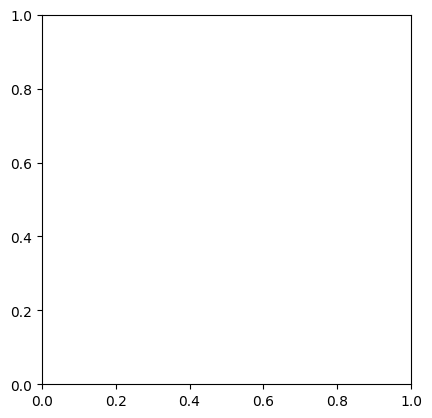

In [ ]:
import torchvision.transforms.functional as TF
import random
import PIL

# preprocess and augment the data if p_[augmentation] > 0
def transformations(image, mask, p_blur = 0, p_noise = 0, p_compress = 0):
  mask = np.load(mask)
  image = TF.pil_to_tensor(image)
  if random.random() < p_blur:
    image = TF.gaussian_blur(image, 5)


  return image, mask

test_img, test_mask = next(dataset).values()
image, mask = transformations(test_img, test_mask, 1)
plt.imshow(image.resha)